# Using This Notebook

To use this notebook, simply run cells from top to bottom. Important cells that have values that you can optionally modify are indicated using Markdown cells like this one. Otherwise, information about the code within each cell is contained within the comments of those cells.

In [2]:
"""
Import packages and Define Constants
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

In [3]:
"""
Utility Function Definitions
"""

def ensure_dims(arr, n_dims):
    """
    Ensures a NumPy array has the correct dimensions.
    :param arr: A given NumPy array.
    :param n_dims: The desired number of dimensions.
    :return: The provided array, with the proper number of dimensions.
    """
    arr = np.array(arr, dtype=np.float32)
    while arr.ndim < n_dims:
        arr = arr[None, :]
    return arr

def point_to_point_distance(x, y, r=1):
    """
    Calculates the distance points, or lists of points. This distance
    can be scaled by setting r.
    :param x: The first point(s) to calculate distance between
    :param y: The second point(s) to calculate distance between
    :param r: The scaling factor of the distance.
    :return: A list of distances.
    """
    return np.linalg.norm(x - y, axis=1) * r

In [4]:
"""
Wall Penalty Function Definitions
"""

def point_to_segment_distance(x, segments):
    """
    Distance from point x to line segment [a, b]
    """
    x = ensure_dims(x, 2)
    segments = ensure_dims(segments, 3)

    a = segments[:, 0] # (M, 2)
    b = segments[:, 1] # (M, 2)
    v = b - a # (M, 2)
    vv = np.sum(v * v, axis=1) # (M,)

    x_exp = x[:, None, :] # (N, 1, 2)
    a_exp = a[None, :, :] # (1, M, 2)
    v_exp = v[None, :, :] # (1, M, 2)

    w = x_exp - a_exp # (N, M, 2)

    t = np.zeros(w.shape[:2], dtype=np.float32) # (N, M)
    mask = vv > 0.0

    if np.any(mask):
        t[:, mask] = (np.sum(w[:, mask] * v_exp[:, mask], axis=2) / vv[mask])

    t = np.clip(t, 0.0, 1.0)

    q = a_exp + t[:, :, None] * v_exp  # (N, M, 2)
    q[:, ~mask] = a_exp[:, ~mask]
    return np.linalg.norm(x_exp - q, axis=2)  # (N, M)

def quadratic_band_penalty(x, segments, r=1):
    """
    Quadratic band cost for walls
    """
    d = point_to_segment_distance(x, segments)
    return np.where(d <= r, 0.5 * (r - d)**2, 0.0)

def quartic_band_penalty(x, segments, r=1):
    """
    Quadratic band cost for walls
    """
    d = point_to_segment_distance(x, segments)
    return np.where(d <= r, (r - d)**4, 0.0)

def truncated_log_barrier(x, segments, r=1):
    """
    Truncated log barrier cost for walls
    """
    d = point_to_segment_distance(x, segments)
    return np.where(d <= r, np.log10(r/(d+1e-9)), 0.0)

def truncated_inverse_distance(x, segments, r=1):
    """
    Truncated inverse distance cost for walls
    """
    d = point_to_segment_distance(x, segments)
    return np.where(d <= r, 1/(d+1e-3), 0.0)

In [5]:
"""
Cost Function Definitions
"""

def cost(
    points,
    walls,
    goal,
    wall_cost_function=quadratic_band_penalty,
    r=1,
    goal_distance_function=point_to_point_distance,
    goal_r=1,
    wall_weights=None
):
    """
    Calculates the cost at a given point (or list of points), given a list
    of walls, a goal function, a wall cost function, and a function that
    defines the cost of the distance from the goal.
    :param points: The point(s) to calculate cost for.
    :param walls: The walls to apply the wall_cost_function to.
    :param goal: The goal point for gradient descent.
    :param wall_cost_function: The function used to calculate the cost
        for approaching a wall.
    :param goal_distance_function: The function use to calculate the cost
        of distance from the goal.
    :param r: The scaling factor of the wall cost.
    :param goal_r: The scaling factor of the goal cost.
    :param wall_weights: The weights of individual walls.
    :return: The cost at each provided point.
    """
    wall_weights = np.array(wall_weights) if wall_weights is not None else np.ones(walls.shape[0])
    if goal is None:
        goal_distances = np.zeros(points.shape[0])
    else:
        goal_distances = goal_distance_function(goal, points, r=goal_r)
    wall_costs = wall_cost_function(points, walls, r=r)
    return goal_distances + np.sum(wall_weights * wall_costs, axis=1)

def cost_gradient(
    points,
    walls,
    goal,
    wall_cost_function=quadratic_band_penalty,
    goal_distance_function=point_to_point_distance,
    r=1,
    goal_r=1,
    wall_weights=None,
    delta=1e-4
):
    """
    Calculates the gradient of the cost at a given point (or list of points).
    :param points: The point(s) to calculate cost for.
    :param walls: The walls to apply the wall_cost_function to.
    :param goal: The goal point for gradient descent.
    :param wall_cost_function: The function used to calculate the cost
        for approaching a wall.
    :param goal_distance_function: The function use to calculate the cost
        of distance from the goal.
    :param r: The scaling factor of the wall cost.
    :param goal_r: The scaling factor of the goal cost.
    :param wall_weights: The weights of individual walls.
    :param delta: The delta used to linearly approximate the gradient at each provided point.
    :return: The cost at each provided point.
    """
    points = ensure_dims(points, 2)
    walls = ensure_dims(walls, 3)
    points_x_delta = points + np.array([delta, 0])
    points_y_delta = points + np.array([0, delta])
    point_costs = cost(points, walls, goal, wall_cost_function, r=r, goal_r=goal_r, goal_distance_function=goal_distance_function, wall_weights=wall_weights)
    x_delta_costs = cost(points_x_delta, walls, goal, wall_cost_function, goal_distance_function=goal_distance_function, r=r, goal_r=goal_r, wall_weights=wall_weights)
    y_delta_costs = cost(points_y_delta, walls, goal, wall_cost_function, goal_distance_function=goal_distance_function, r=r, goal_r=goal_r, wall_weights=wall_weights)
    x_partials = (x_delta_costs - point_costs) / delta
    y_partials = (y_delta_costs - point_costs) / delta
    gradients = np.stack([x_partials, y_partials], axis=1)
    return gradients

In [6]:
"""
Plotting Function Definitions
"""

def draw_floor_plan(
    walls,
    start=None,
    end=None,
    ax=None
):
    """
    Draws a simple plot of a provided floor plan
    :param walls: A list of walls, where each wall is provided in the form [[x1, y1], [x2, y2]]
    :param start: The starting point for the gradient descent algorithm
    :param end: The ending point for the gradient descent algorithm
    :param ax: An optional matplotlib axes object. If provided, the plot will not be automatically shown.
    :return: None
    """
    show = False
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
        show = True
    for wall in walls:
        ax.plot(wall[:, 0], wall[:, 1], color='#000000', linewidth=2, linestyle='-')
    if start is not None:
        ax.scatter(start[0], start[1], color='#00FF00')
    if end is not None:
        ax.scatter(end[0], end[1], color='#FF0000')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    if show:
        plt.show()

def plot_cost_field(
    walls,
    start,
    goal,
    cost_function=quadratic_band_penalty,
    goal_distance_function=point_to_point_distance,
    r=1,
    goal_r=1,
    resolution=32,
    vector_resolution=16,
    wall_weights=None,
    ax=None,
    show_walls=True,
    show_vectors=True
):
    show = False
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
        show = True
    x_min, x_max = 0, 10
    y_min, y_max = 0, 10
    x_space = np.linspace(x_min, x_max, resolution)
    y_space = np.linspace(y_min, y_max, resolution)
    x_mesh, y_mesh = np.meshgrid(x_space, y_space)
    cost_field_points = np.stack([x_mesh, y_mesh], axis=-1).reshape(-1, 2)
    costs = cost(cost_field_points, walls, goal, wall_cost_function=cost_function, r=r, goal_r=goal_r, goal_distance_function=goal_distance_function, wall_weights=wall_weights)
    costs = costs.reshape(resolution, resolution)
    contour = plt.contourf(x_space, y_space, costs, levels=200, cmap='plasma')
    if show_walls:
        draw_floor_plan(walls, start, goal, ax=ax)
    if show_vectors:
        x_vector_space = np.linspace(x_min, x_max, vector_resolution)
        y_vector_space = np.linspace(y_min, y_max, vector_resolution)
        x_vector_mesh, y_vector_mesh = np.meshgrid(x_vector_space, y_vector_space)
        vector_field_points = np.stack([x_vector_mesh, y_vector_mesh], axis=-1).reshape(-1, 2)
        vector_gradients = cost_gradient(vector_field_points, walls, goal, wall_cost_function=cost_function, goal_distance_function=goal_distance_function, r=r, goal_r=goal_r, wall_weights=wall_weights)
        x_gradients, y_gradients = -vector_gradients[:, 0], -vector_gradients[:, 1]
        plt.quiver(vector_field_points[:, 0], vector_field_points[:, 1], x_gradients, y_gradients, color='#FFFFFF')
    plt.colorbar(contour)
    if show:
        plt.show()

In [7]:
"""
Gradient Descent Implementation
"""

def gradient_descent(
        walls,
        start,
        goal,
        cost_function=quadratic_band_penalty,
        goal_distance_function=point_to_point_distance,
        r=1,
        goal_r=1,
        step_size=0.05,
        wall_weights=None,
        max_iterations=10000
):
    """
    Performs a gradient descent from a starting point to a goal point, returning
    the list of points visited to get from the start point to the goal.
    :param walls: A list of walls, where each wall is provided in the form [[x1, y1], [x2, y2]]
    :param wall_weights: A list of weights corresponding to each provided wall.
    :param start: The starting point for the gradient descent algorithm
    :param goal: The end goal for the gradient descent algorithm
    :param cost_function: The cost function to use for the walls during gradient descent
    :param r: The scaling factor for the wall cost function
    :param goal_distance_function: The cost function to use for the distance from the goal point
    :param goal_r: The scaling factor for the goal cost function
    :param step_size: How far the gradient descent algorithm should step each iteration
    :param max_iterations: The maximum number of iterations gradient descent should run
        for before "auto-failing".
    :return:
    """
    start = np.array(start, dtype=np.float32)
    goal = np.array(goal, dtype=np.float32)

    current_position = start.copy()
    path = [current_position.copy()]
    current_iteration = 0

    while np.linalg.norm(goal - current_position) > 0.1 and current_iteration < max_iterations:
        gradient = cost_gradient(current_position, walls, goal, cost_function, r=r, goal_r=goal_r, goal_distance_function=goal_distance_function, wall_weights=wall_weights)
        gradient = -gradient[0] / np.linalg.norm(gradient) * step_size
        current_position += gradient
        path.append(current_position.copy())
        current_iteration += 1

    return np.array(path)

In [8]:
"""
Generate Floor Plans
"""

single_wall = (np.array([
    [[5, 2], [5, 8]]
], dtype=np.float32),
np.array([2, 2], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

baseline_floor_plan = (np.array([
    [[0, 0], [0, 10]],
    [[0, 10], [10, 10]],
    [[10, 10], [10, 0]],
    [[10, 0], [0, 0]],
    [[4, 0], [4, 7]],
    [[4, 7], [8, 7]],
    [[8, 7], [8, 3]],
], dtype=np.float32),
np.array([2, 2], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

zigzag_floor_plan = (np.array([
    [[0, 0], [0, 6]],
    [[4, 10], [10, 10]],
    [[10, 10], [10, 8]],
    [[2, 0], [0, 0]],
    [[2, 0], [2, 4]],
    [[2, 4], [4, 4]],
    [[4, 4], [4, 6]],
    [[4, 6], [6, 6]],
    [[6, 6], [6, 8]],
    [[6, 8], [10, 8]],
    [[0, 6], [2, 6]],
    [[2, 6], [2, 8]],
    [[2, 8], [4, 8]],
    [[4, 8], [4, 10]],
]),
np.array([1, 1], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

symmetric_plan = (np.array([
    [[0, 0], [0, 10]],
    [[0, 10], [10, 10]],
    [[10, 10], [10, 0]],
    [[10, 0], [0, 0]],
    [[2, 8], [8, 2]]
]),
np.array([1, 1], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

dead_end_plan = (np.array([
    [[0, 0], [0, 10]],
    [[0, 10], [10, 10]],
    [[10, 10], [10, 0]],
    [[10, 0], [0, 0]],
    [[8, 6], [6, 8]],
    [[8, 6], [4, 2]],
    [[6, 8], [2, 4]]
]),
np.array([1, 1], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

## Interactive Values

For the sake of demonstration, the below parameters can be set to modify the behavior of the following cells, up until the Markdown cell labeled "END OF DEMONSTRATION CELLS"

Below are descriptions of each of the modifiable variables:
- `RESOLUTION` - Sets the number of samples points on both the x and y axes for the sake of generating contour of the cost function. It is recommended that you leave this value at $128$. Lower values may cause the contour gradients to appear "choppy", higher values will take more computation time, but have little to no visual effect on the resulting plots.
- `VECTOR_RESOLUTION` - Sets the number of sample points on both the x and y axes for the sake of generating a vector field of the cost function. It is recommended that you leave this value at $20$. Lower values will not give a good indication of the direction of the gradient across the plot, and higher values will result in a very densely packed vector field, making the plot difficult to interpret.
- `CHOSEN_PLAN` - Sets the floor plan to plot and use for demonstration. Allowed values are:
  - `single_wall` - A floor plan with a single wall
  - `baseline_floor_plan` - A simple floor plan of a closed room with a series of walls
  - `zigzag_floor_plan` - A narrow corridor with zig-zagging walls
  - `symmetric_plan` - A floor plan where a single wall blocks the start from the goal in a symmetric fashion
  - `dead_end_plan` - A floor plan where a single dead-end hallway exists between the start and the goal
- `PENALTY_FUNCTION` - The penalty function that is used to determine the penalty for approaching walls. Allowed values are:
  - `quadratic_band_penalty`
  - `quartic_band_penalty`
  - `truncated_log_barrier`
  - `truncated_inverse_distance`
  - `reciprocal_penalty` - A custom penalty function I came up with (very simple, see function definition in cells above)
- `GOAL_DISTANCE_FUNCTION` - The function to used to determine the penalty for moving away from the goal (and thus the gain for moving towards the goal). _Should not be changed from_ `point_to_point_distance`,
- `PENALTY_RADIUS` - The radius from each wall at which the `PENALTY_FUNCTION` comes into effect. Values from $1-3$ tend to yield good results.
- `GOAL_SCALE_FACTOR` - A scale factor for the `GOAL_DISTANCE_FUNCTION`. Values from $1-3$ tend to yield good results.

In [9]:
RESOLUTION = 128
VECTOR_RESOLUTION = 20

CHOSEN_PLAN = single_wall
PENALTY_FUNCTION = quadratic_band_penalty
GOAL_DISTANCE_FUNCTION = point_to_point_distance
PENALTY_RADIUS = 2.5
GOAL_SCALE_FACTOR = 2

In [10]:
floor_plan, start_point, end_point = CHOSEN_PLAN

## Floor Plan Visualizatoin

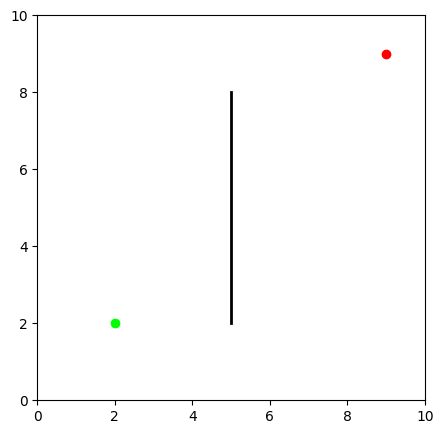

In [11]:
draw_floor_plan(floor_plan, start_point, end_point)

## Cost Field Visualization (Walls Only)

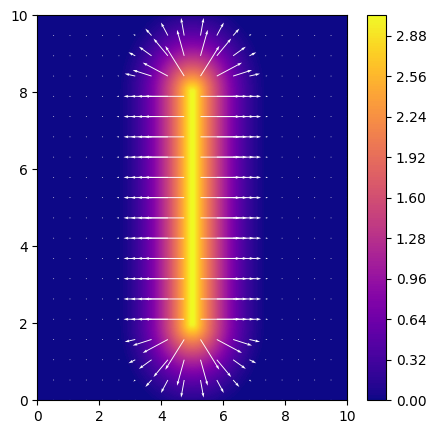

In [12]:
"""""
Visualize Cost Field
"""
plot_cost_field(
    floor_plan,
    start_point,
    None,
    cost_function=PENALTY_FUNCTION,
    goal_distance_function=GOAL_DISTANCE_FUNCTION,
    r=PENALTY_RADIUS,
    goal_r=GOAL_SCALE_FACTOR,
    resolution=RESOLUTION,
    vector_resolution=VECTOR_RESOLUTION,
    show_walls=False,
    show_vectors=True
)

## Cost Field Visualization (Walls and Goal)

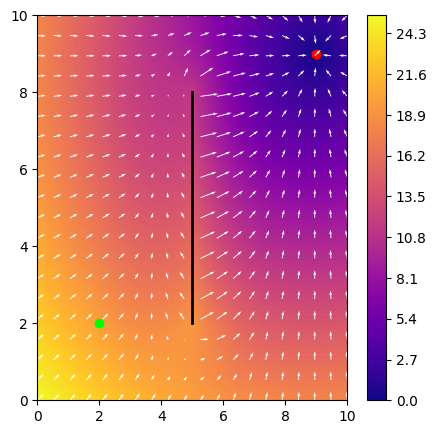

In [13]:
"""""
Visualize Cost Field
"""
plot_cost_field(
    floor_plan,
    start_point,
    end_point,
    cost_function=PENALTY_FUNCTION,
    goal_distance_function=GOAL_DISTANCE_FUNCTION,
    r=PENALTY_RADIUS,
    goal_r=GOAL_SCALE_FACTOR,
    resolution=RESOLUTION,
    vector_resolution=VECTOR_RESOLUTION,
    show_walls=True,
    show_vectors=True
)

## Gradient Descent Path Visualization

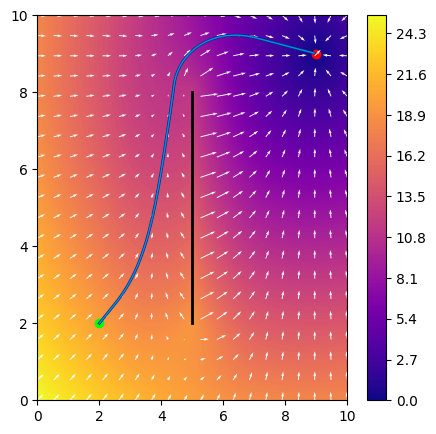

In [14]:
path = gradient_descent(
    floor_plan,
    start_point,
    end_point,
    cost_function=PENALTY_FUNCTION,
    goal_distance_function=GOAL_DISTANCE_FUNCTION,
    r=PENALTY_RADIUS,
    goal_r=GOAL_SCALE_FACTOR
)
_, ax = plt.subplots(figsize=(5, 5))
plot_cost_field(
    floor_plan,
    start_point,
    end_point,
    PENALTY_FUNCTION,
    goal_distance_function=GOAL_DISTANCE_FUNCTION,
    r=PENALTY_RADIUS,
    goal_r=GOAL_SCALE_FACTOR,
    resolution=RESOLUTION,
    vector_resolution=VECTOR_RESOLUTION,
    ax=ax
)
plt.plot(path[:, 0], path[:, 1], color='#0088FF', lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='#003366'), pe.Normal()])
plt.show()

## END OF DEMONSTRATION CELLS

# Analysis of Cost Functions

In [15]:
resolution = 128
vector_resolution = 20

chosen_plan = single_wall
penalty_function = truncated_log_barrier
goal_distance_function = point_to_point_distance
penalty_radius = 1
goal_scale_factor = 2

In [16]:
floor_plan, start_point, end_point = chosen_plan

## Floor Plan Visualizatoin

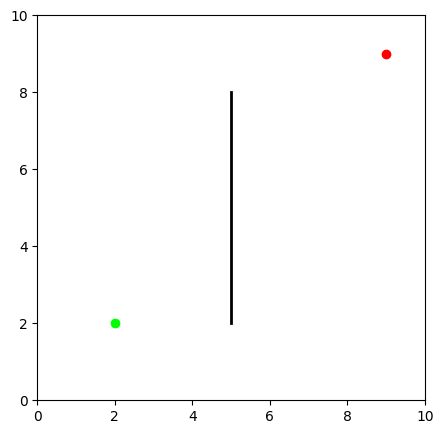

In [17]:
draw_floor_plan(floor_plan, start_point, end_point)

## Cost Field Visualization (Walls Only)

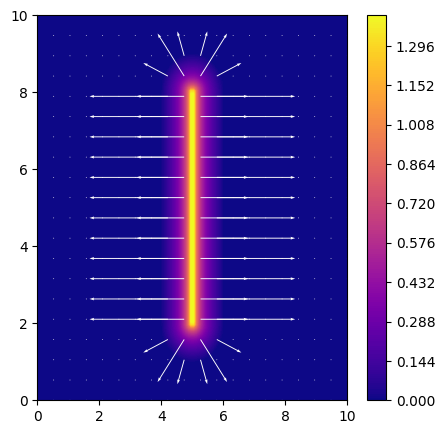

In [18]:
"""""
Visualize Cost Field
"""
plot_cost_field(
    floor_plan,
    start_point,
    None,
    cost_function=penalty_function,
    goal_distance_function=goal_distance_function,
    r=penalty_radius,
    goal_r=goal_scale_factor,
    resolution=resolution,
    vector_resolution=vector_resolution,
    show_walls=False,
    show_vectors=True
)

## Cost Field Visualization (Walls and Goal)

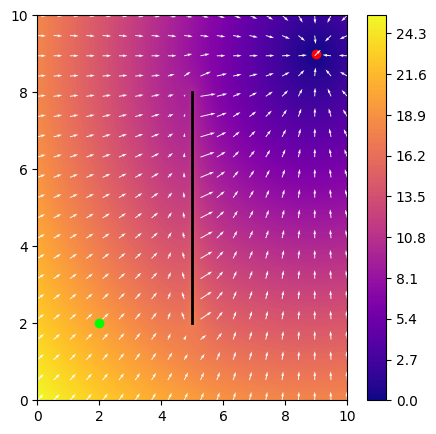

In [19]:
"""""
Visualize Cost Field
"""
plot_cost_field(
    floor_plan,
    start_point,
    end_point,
    cost_function=penalty_function,
    goal_distance_function=goal_distance_function,
    r=penalty_radius,
    goal_r=goal_scale_factor,
    resolution=resolution,
    vector_resolution=vector_resolution,
    show_walls=True,
    show_vectors=True
)

## Gradient Descent Path Visualization

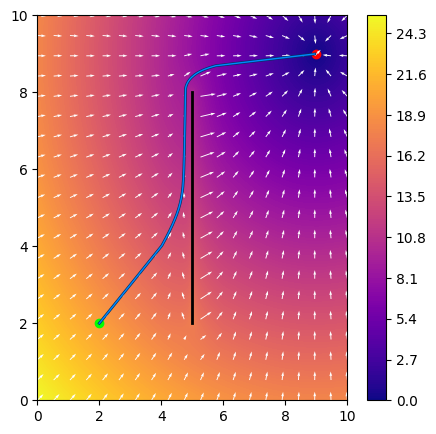

In [20]:
path = gradient_descent(
    floor_plan,
    start_point,
    end_point,
    cost_function=penalty_function,
    goal_distance_function=goal_distance_function,
    r=penalty_radius,
    goal_r=goal_scale_factor
)
_, ax = plt.subplots(figsize=(5, 5))
plot_cost_field(
    floor_plan,
    start_point,
    end_point,
    penalty_function,
    goal_distance_function=goal_distance_function,
    r=penalty_radius,
    goal_r=goal_scale_factor,
    resolution=resolution,
    vector_resolution=vector_resolution,
    ax=ax
)
plt.plot(path[:, 0], path[:, 1], color='#0088FF', lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='#003366'), pe.Normal()])
plt.savefig('temp.png')
plt.show()

## Results

All analysis done with `GOAL_SCALE_FACTOR` $=2$

### Quadratic Band Penalty
- Path smoothness: Smooth when $r > 2$, otherwise can lead to sharp corners, or crossing over walls.
- Clearance from walls: Bad for $r=2$, path will approach very close to walls. $r > 1.5$ yields the best clearance results.
- Sensitivity to parameters: Performance of penalty function is very dependent on $r$ (`PENALTY_RADIUS`) and `GOAL_SCALE_FACTOR`. Mis-setting parameters can easily lead to failure to reach the goal, or crossing over walls.
- Presence of local minima: Issues arose when trying to pathfind through the `zigzag_wall_plan`. Algorithm consistently got stuck in local minima, even after tinkering with `GOAL_SCALE_FACTOR` and `PENALTY_RADIUS`
- Numerical stability: Very stable. Maximum cost for a single wall is guaranteed to be $\le r^2$

#### Discussion Points:

**Why trajectories may "graze" walls:** Quadratic band penalty is prone to this issue because the scale of the cost does not increase dramatically until the distance between a point in the wall is very small (especially for lower values of $r$). Therefore, the algorithm can get very close to walls without being penalized.

$r = 2$

<img src="images/quadratic_r_2_close.png" width="300"/>

$r = 3$

<img src="images/quadratic_r_3_close.png" width="300"/>

**Trade-off between smoothness and safety:** In order to have a penalty function that increases "smoothly" as you approach a wall, it must also not grow too quickly close to the wall, meaning the function is more prone to potentially having the point "jump" over walls.

$r = 1$

<img src="images/quadratic_jump_over_wall.png" width="300"/>

### Quartic Band Penalty
- Path smoothness: Paths are generally smooth regardless of $r$ value, often taking circular paths around corners.
- Clearance from walls: $1 \le r < 1.5$ can produce poor wall clearance, but $r \ge 1.5$ produces good wall clearance.
- Sensitivity to parameters: A bit more robust than quadratic band penalty, but still prone to issues such as skipping over walls if $r$ is too low, and producing local minima of $r$ is too high (say, $r \ge 3$).
- Presence of local minima: Able to navigate `zigzag_wall_pattern` without issue when $1 \le r \le 1.5$.
- Numerical stability: Stable. Maximum cost for a single wall is guaranteed to be $\le r^4$.

#### Discussion Points:

**How higher-order penalties change path curvature:** In some aspects, quartic and quadratic share similar behaviors. However, the quartic penalty tends to steer the algorithm further away from walls for the same $r$ value (makes sense, since the exponent for quartic is larget than that of quadratic). This sometimes results in smoother paths, but at the cost of wider turns and longer paths.

Quadratic, $r = 2$

<img src="images/quadratic_r_2.png" width="300"/>

Quartic, $r = 2$

<img src="images/quartic_r_2.png" width="300"/>

**Comparison with inverse-distance penalties:** Quartic band penalty seems to be more prone to local minima issues when compared to truncated inverse distance. However, truncated inverse distance tends to have issues with finding smooth paths to the goal, whereas this tends to not be an issue with quartic band penalty.

Quartic, $r=1$

<img src="images/quartic_zigzag.png" width="300"/>

Truncated Inverse Distance, $r=1$

<img src="images/truncated_inverse_distance_zigzag.png" width="300"/>

### Truncated Log Barrier
- Path smoothness: Paths can be very sharp when navigating around tight hallways, such as in `zigzag_wall_plan`
- Clearance from walls: Low clearance from wall, and clearance scales very poorly with $r$.
- Sensitivity to parameters: Not very sensitive to $r$, due to the $log$ function contained within the cost calculation.
- Presence of local minima: The presence of the $log$ function within the cost function means that cost is very low up until the point is very close to walls, at which points it spikes dramatically. This behavior helps minimize the presence of local minima.
- Numerical stability: Stable. Maximum cost for a single wall is guaranteed to be $\le \frac{r}{log(\epsilon)}$ (where $\epsilon=10^{-9}$).

#### Discussion Points

**Sensitivity to $\epsilon$:** The truncated log barrier is not particularly sensitive to the $\epsilon$ value, as long as it is sufficiently small for the penalty function to still serve its purpose. Below are three plots showing relatively the same traversal for three different $\epsilon$ values. Notably, the $\epsilon$ value plays a small role in determining how close the path can approach the walls.

$\epsilon=10^{-1}$

<img src="images/truncated_barrier_epsilon_10e-1.png" width="300"/>

$\epsilon=10^{-3}$

<img src="images/truncated_barrier_epsilon_10e-3.png" width="300"/>

$\epsilon=10^{-9}$

<img src="images/truncated_barrier_epsilon_10e-9.png" width="300"/>

**Behavior near corners:** For both lower and higher $r$ values, truncated log barrier was able to produce relatively smooth turns around corners.

$r=1$

<img src="images/truncated_r_1.png" width="300"/>

$r=1.5$

<img src="images/truncated_r_1.5.png" width="300"/>

$r=3$

<img src="images/truncated_r_3.png" width="300"/>

**Numerical stiffness:** Because of the inclusion of the $log$ function within the truncated log barrier function, it is difficult to modify the behavior of the function without changing the values of $r$ or $\epsilon$ by orders of magnitude, making the function quite stubborn to change.

### Truncated Inverse Distance
- Path smoothness: Paths are sharp when $r < 2$, and smoother when $r \ge 2$. However, other factors may require that $r < 2$, making sharp-angled paths unavoidable.
- Clearance from walls: Decent clearance from walls, even at lower $r$ values.
- Sensitivity to parameters: Barely sensitive to $r$, since $r$ is not used in the calculation of the penalty itself.
- Presence of local minima: Because of the nature of the function increasing rapidly only at values very close to the walls, local minima were not much of an issue (at least, not beyond the standard issues where local minima are unavoidable, such as dead ends).
- Numerical stability: Slightly unstable. Maximum cost for a single wall is guaranteed to be $\le \frac{1}{(\epsilon)}$ (where $\epsilon=10^{-3}$). It may not always be great that increase by orders of magnitude across such a small distance.

## General Analysis

1. How does wall thickness or influence radius affect the resulting path?

Wall thickness/influence radius being higher generally meant that the path would tend to stay further away from the walls where possible.

2. What happens near corners or narrow corridors?

Around corners, the path would typically take wider turns, since a corner is an intersection of two walls, and thus a corner would essentially have double the cost than the middle of a wall. For narrow hallways, the path would often try to remain directly in the middle of the two walls

3. Does the method ever get stuck? Why or why not?

Yes, the method gets stuck when there is a dead end in front of it, or when presented with a scenario where the path would have to go significantly far away from the end goal in order to reach the goal. This is because the cost function penalizes moving away from the goal, making the algorithm prioritize shorter paths that always tend towards the end goal, even if that means the algorithm will end up in a dead end.